# Sample processing of k-mer feature extraction and dimensionality reduction

This notebook attempts to show the reproducibility of our research by extracting the 3mer spectrum feature from a subsample of roughly 7.8k SARS-CoV-2 sequences.

In [1]:
# Loading of relevant modules:

import pacmap # pip install pacmap
from NVs import * # needs: pip install more_itertools
import classix # pip install classixclustering
from Bio import SeqIO # pip install biopython
import hdbscan # pip install hdbscan

# Loading of tools for preprocessing, qualitative evaluation and plotting:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import NullFormatter

# Activation of inline plotting
%matplotlib inline

1. listing of fasta files to be processed:

In [2]:
files = ['25MBVOISampling_00_UAL_file.fasta', '25MBVOISampling_01_UAL_file.fasta',
         '25MBVOISampling_02_UAL_file.fasta', '25MBVOISampling_03_UAL_file.fasta',
         '25MBVOISampling_04_UAL_file.fasta', '25MBVOISampling_05_UAL_file.fasta',
         '25MBVOISampling_06_UAL_file.fasta', '25MBVOISampling_07_UAL_file.fasta',
         '25MBVOISampling_08_UAL_file.fasta', '25MBVOISampling_09_UAL_file.fasta']

2. Preprocessing of the sequences to 3mer spectrum feature and consolidation in a single DataFrame

In [3]:
kmc = pd.DataFrame()
for file in files:
    records = SeqIO.parse(open(file, 'r'), 'fasta')
    for record in records:
        taxonNlabel = record.id.split('$$')
        sequence = ''.join(record.seq)
        feature = kmerCount(sequence, k=3)
        cols = list(feature.keys())
        data = list(feature.values())
        
        df = pd.DataFrame(columns=['taxon', 'label']+cols, 
                          data=[taxonNlabel+data] )
        kmc = pd.concat([kmc, df], ignore_index=True)
kmc.drop_duplicates(inplace=True)

3. Retrival, normalisation, formating of data (X) and labels (y) and dimensionality reduction through PaCMAP

In [4]:
X = kmc.iloc[:, 2:]
X = MinMaxScaler().fit_transform(X)
y = kmc.iloc[:, 1].values.T

embedding = pacmap.PaCMAP(n_components=3)
X_PaCMAP = embedding.fit_transform(X).T

4. Clustering processes and qualitative evaluation by Adjusted Rand and Adjusted Mutual Information scores

In [5]:
hd = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=2000)
hdbscan_labels = hd.fit_predict(X_PaCMAP.T)
hdbscan_rand, hdbscan_mutual = adjusted_rand_score(y, hdbscan_labels), adjusted_mutual_info_score(y, hdbscan_labels)
cl = classix.CLASSIX(radius=0.125, minPts=50, group_merging='distance', post_alloc=False,
            verbose=0) 
classix_labels = cl.fit_transform(X_PaCMAP.T)
classix_rand, classix_mutual = adjusted_rand_score(y, classix_labels), adjusted_mutual_info_score(y, classix_labels)

C:\Users\v95983rc\.conda\envs\DimRedCovid19\lib\site-packages\classix\clustering.py:451: UserWarning: This CLASSIX installation is not using Cython.
  warnings.warn("This CLASSIX installation is not using Cython.")


5. Plotting of results.

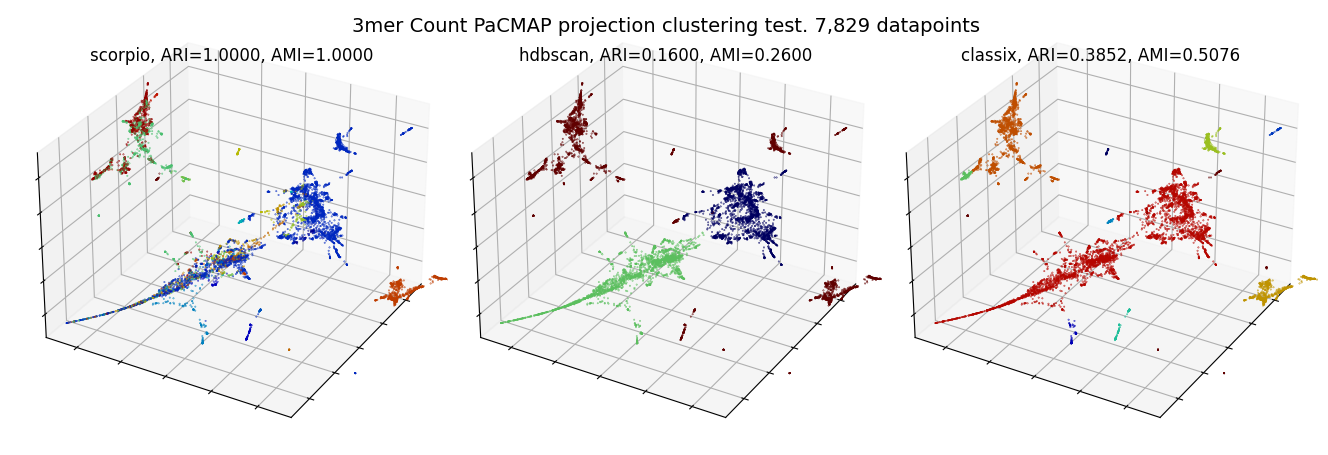

In [6]:
clusterings = {'scorpio': [LabelEncoder().fit_transform(y), 1.0, 1.0],
               'hdbscan': [hdbscan_labels, hdbscan_rand, hdbscan_mutual],
               'classix': [classix_labels, classix_rand, classix_mutual]}

newcolors = mpl.cm.jet_r(np.linspace(0,1,256))
newcolors = np.array([[ch*0.75 for ch in v[:-1]] for v in newcolors])
newjet = mpl.colors.ListedColormap(newcolors)

fig = plt.figure(figsize=[15, 5])
fig.suptitle(f'3mer Count PaCMAP projection clustering test. {len(y):,.0f} datapoints', 
             x=0.5, y=0.85, ha='center', va='bottom', 
             transform=fig.transFigure, fontsize=14)

for i, (classification, (labels, rand, mutual)) in enumerate(clusterings.items(),1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.scatter(*X_PaCMAP, c=labels, s=0.1, alpha=1.0, cmap=newjet)
    ax.set_title(f'{classification}, ARI={rand:.4f}, AMI={mutual:.4f}', 
             x=0.5, y=0.95, ha='center', va='bottom', 
             transform=ax.transAxes);
    ax.view_init(elev=30, azim=30)
    lim = 13
    ax.set_ylim(-lim,lim); ax.set_xlim(-lim,lim); ax.set_zlim(-lim,lim);
    ax.xaxis.set_major_formatter(NullFormatter());
    ax.yaxis.set_major_formatter(NullFormatter());
    ax.zaxis.set_major_formatter(NullFormatter());

fig.tight_layout(h_pad=0.0, w_pad=-12)